# PASEOS Orekit integration example

This example requires an [orekit installation](https://gitlab.orekit.org/orekit-labs/python-wrapper/-/wikis/installation) via conda. (Note that orekit requires Java)

It showcases how to adapt an example from the [orekit documentation](https://gitlab.orekit.org/orekit-labs/python-wrapper/-/blob/master/examples/Example_numerical_prop.ipynb ) to utilize orekit for position and velocity calculations inside PASEOS.

Additionally, you will need to place the orekit [data](https://gitlab.orekit.org/orekit/orekit-data) as `orekit-data.zip` in the same folder as this notebook. (N.B. don't decompress the zip file)

In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("..")
sys.path.append("../..")

import paseos
from paseos import ActorBuilder, SpacecraftActor

import pykep as pk
import matplotlib.pyplot as plt

import orekit

from orekit.pyhelpers import setup_orekit_curdir
from orekit_propagator import OrekitPropagator
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from orekit.pyhelpers import absolutedate_to_datetime


# Initialize the orekit virtual machine and set the current directory
vm = orekit.initVM()
setup_orekit_curdir()

## Initialize the propagator

In [2]:
# Set a start date
utc = TimeScalesFactory.getUTC()
epoch = AbsoluteDate(2020, 1, 1, 0, 0, 00.000, utc)

# Let's define some orbit and a satellite mass
# We use an orbit with a semi-major axis of 7000 km, a eccentricity of 0.5 and an inclination of 0°
orbital_elements = [10000000.0, 0.75, 0.0001, 0.0, 0.0, 0.0]
satellite_mass = 1000.0

# Initialize the propagator
propagator = OrekitPropagator(orbital_elements, epoch, satellite_mass)

## Check the orbit propagation

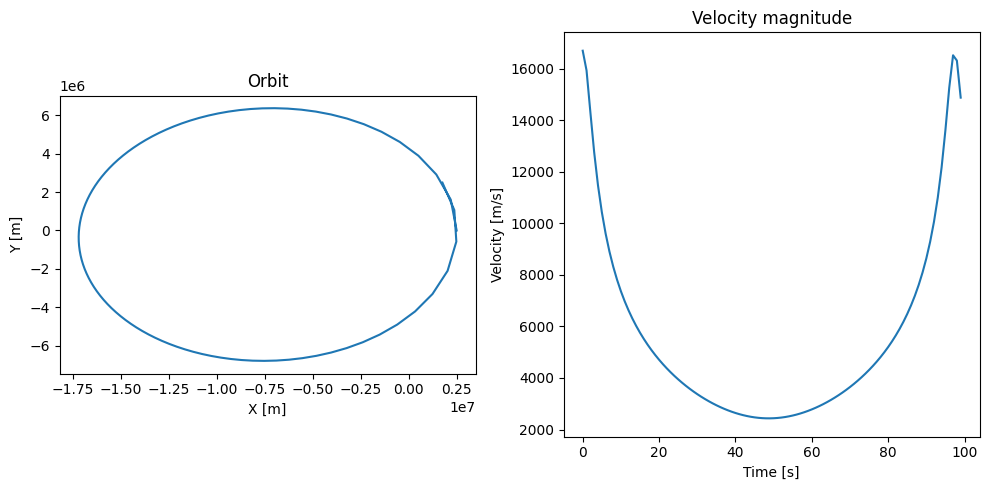

In [3]:
# We can check it works by propagating a bit
r,v = [], []
for t in range(0, 10000, 100):
    state = propagator.eph(float(t))
    r.append(state.getPVCoordinates().getPosition())
    v.append(state.getPVCoordinates().getVelocity())

# Plot the orbit and velocity magnitude
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot([i.getX() for i in r], [i.getY() for i in r])
ax[0].set_xlabel("X [m]")
ax[0].set_ylabel("Y [m]")
ax[0].set_title("Orbit")
ax[0].set_aspect("equal", "box")
ax[1].plot([i.getNorm() for i in v])
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Velocity [m/s]")
ax[1].set_title("Velocity magnitude")
fig.tight_layout()
plt.show()

## Using it with PASEOS

In [4]:
# Convert to pykep epoch
date_string = absolutedate_to_datetime(epoch).strftime("%Y-%m-%d %H:%M:%S")
pykep_epoch = pk.epoch_from_string(date_string)

# Create a spacecraft actor
my_sat = ActorBuilder.get_actor_scaffold(name="my_sat", actor_type=SpacecraftActor, epoch=pykep_epoch)

Now we need to define a function that returns position and velocity given an epoch. We will use our propagator for this.

In [5]:
def propagator_function(epoch: pk.epoch):
    """Propagator function for the spacecraft actor.

    Args:
        epoch (pk.epoch): Epoch to propagate to. (can be expensive!)

    Returns:
        list: List of position and velocity.
    """
    # Compute the time since the start of the simulation
    time_since_start = (epoch.mjd2000 - pykep_epoch.mjd2000) * pk.DAY2SEC

    # Propagate the orbit
    state = propagator.eph(time_since_start)

    # Return the position and velocity as a list
    r = list(state.getPVCoordinates().getPosition().toArray())
    v = list(state.getPVCoordinates().getVelocity().toArray())
    
    return r, v

# Set the custom orbit
ActorBuilder.set_custom_orbit(my_sat, propagator_function, pykep_epoch)

# Create a PASEOS instance
instance = paseos.init_sim(local_actor=my_sat)

Let's check if it works by running the PASEOS simulation for this actor and get the position as before.

If everything went well, you should see the same plot again, except this time it's happening inside PASEOS.

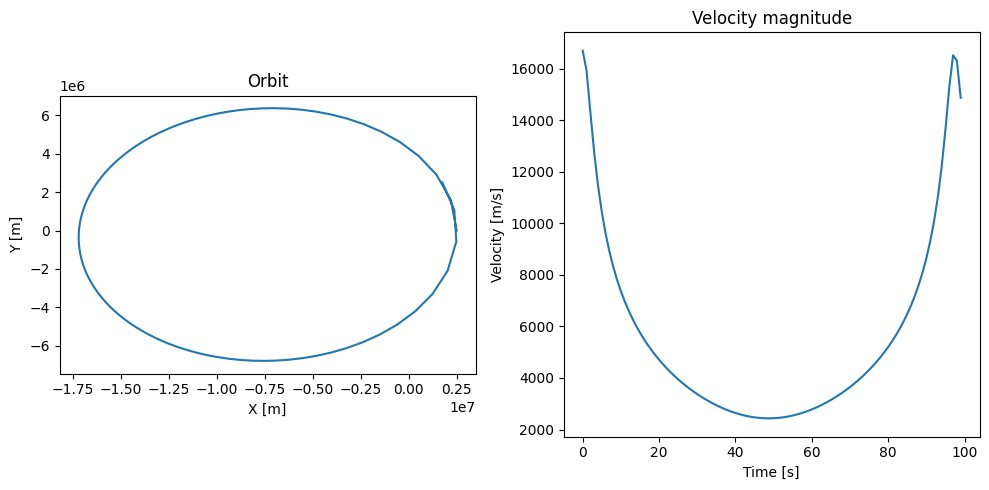

In [6]:
import numpy as np
# We can check it works by propagating a bit
r,v = [], []
for _ in range(0, 10000, 100):
    current_epoch = instance.local_time
    r_t,v_t = my_sat.get_position_velocity(current_epoch)
    r.append(r_t)
    v.append(v_t)
    instance.advance_time(time_to_advance=100.0, current_power_consumption_in_W=0.0)

# Plot the orbit and velocity magnitude
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot([i[0] for i in r], [i[1] for i in r])
ax[0].set_xlabel("X [m]")
ax[0].set_ylabel("Y [m]")
ax[0].set_title("Orbit")
ax[0].set_aspect("equal", "box")
ax[1].plot([np.linalg.norm(i) for i in v])
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Velocity [m/s]")
ax[1].set_title("Velocity magnitude")
fig.tight_layout()
plt.show()